# Logistic Regression, Bayes and EM

## We will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize the results.

In [2]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [4]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

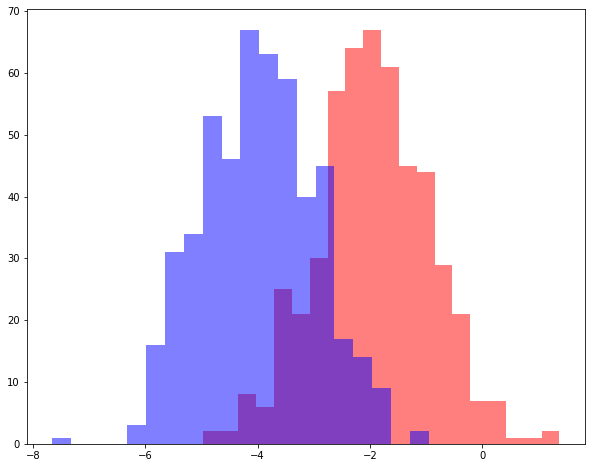

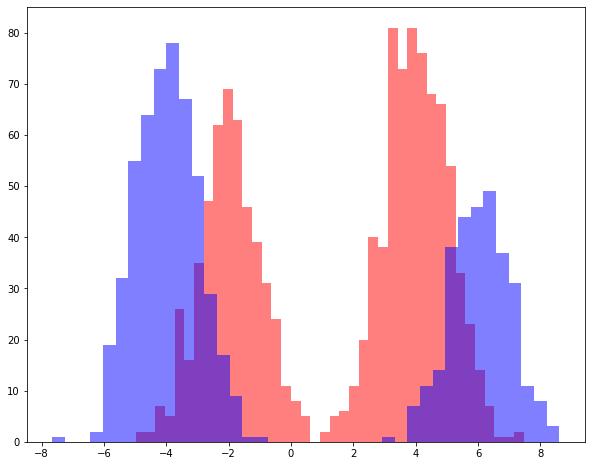

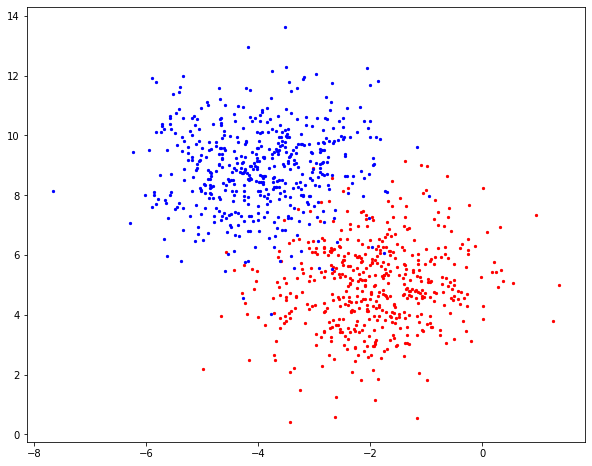

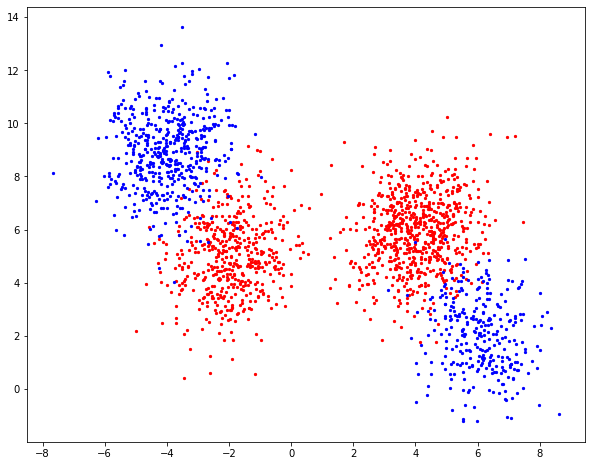

In [5]:
#For the first 1000 data points plot a histogram for each class on the same graph
first1000 = training_set[:1000]
Byy0 = first1000[(first1000['y'].values == 0)][['x1', 'x2']].values
Byy1 = first1000[(first1000['y'].values == 1)][['x1', 'x2']].values
plt.hist(Byy0[:, 0], alpha=0.5, bins=20, color='red')
plt.hist(Byy1[:, 0], alpha=0.5, bins=20, color='blue')
plt.show()

#For all the data points plot a histogram for each class on the same graph
Byy00 = training_set[(training_set['y'].values == 0)][['x1', 'x2']].values
Byy11 = training_set[(training_set['y'].values == 1)][['x1', 'x2']].values
plt.hist(Byy00[:, 0], alpha=0.5, bins=40, color='red')
plt.hist(Byy11[:, 0], alpha=0.5, bins=40, color='blue')
plt.show()

#For the first 1000 data points plot a scatter plot where each class has different color
plt.scatter(Byy0[:, 0],Byy0[:, 1] , s = 5, color = 'red')
plt.scatter(Byy1[:, 0],Byy1[:, 1] , s = 5, color = 'blue')
plt.show()

#For all the data points plot a scatter plot where each class has different color
plt.scatter(Byy00[:, 0],Byy00[:, 1] , s = 5, color = 'red')
plt.scatter(Byy11[:, 0],Byy11[:, 1] , s = 5, color = 'blue')
plt.show()

## Logistic Regression

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Contains the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed


In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = []
        self.J_history = []
        

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        oneArray = np.ones(X.shape[0])
        X = np.column_stack((oneArray, X))
        self.theta = np.random.RandomState(self.random_state).normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.J_history = []
        
        for i in range(self.n_iter):
            self.J_history.append(self.compute_cost(X,y,self.theta))
            self.theta = self.theta - self.eta*(X.T.dot(self.sigmod(X.dot(self.theta.T)) - y))
            if ((i>0) and (self.J_history[i-1]-self.J_history[i]<(self.eps))): break
            if ((i>0) and ((self.J_history[i-1])<=(self.J_history[i]))): break
        pass
    
    def sigmod(self, X):
        return (1/ (1+ np.exp(-X)))
    
    def predict(self, X):
        """Return the predicted class label"""
        ones = np.ones(len(X))
        X = np.column_stack((ones, X))
        return np.round(self.sigmod(X.dot(self.theta.T)))
                   
    def compute_cost(self,X,y,theta):
        m = X.shape[0]
        p = (1/m) * ((np.log(self.sigmod(X.dot(theta.T))).dot(-y)) - np.log(1-(self.sigmod(X.dot(theta.T)))).dot(1-y))
        if(pd.isnull(p)): return 0
        return p

    
    def accuracy(self, X,y):
        output = [a == b for a,b in zip(X,y)]
        return sum(output)/len(output)

## Cross Validation

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
def partition(data,fold,k):
    size = data.shape[0]
    start = int((size/k)*fold)
    end = int((size/k)*(fold+1))
    if end>size: end=size
    training = np.concatenate((data[:start], data[end:]))
    testing = data[start:end]
    return training, testing

In [8]:
k=5
data = np.column_stack((X_training, y_training))
np.random.seed(42)
np.random.shuffle(data)

#FoldsOfData = np.array_split(data,k)

etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
bestEta = 0.05
bestEps = 0.01
best_accuracy = 0
for i in etas:
    for j in epss:
        LRGD = LogisticRegressionGD(eta=i, eps=j)
        accuracy = 0
        for t in range(0,k):
            training , testing = partition(data, t, k)
            LRGD.fit(training[:,0:-1], training[:,-1])
            accuracy += LRGD.accuracy(LRGD.predict(testing[:,0:-1]),testing[:,-1])
        accuracy = accuracy/k
        if(accuracy > best_accuracy):
            best_accuracy = accuracy
            bestEta = i
            bestEps = j
            

print("best eta" + str(bestEta))
print("best eps" + str(bestEps))

best eta5e-05
best eps1e-06


## Normal distribution pdf

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
An efficient vectorized code

In [9]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    left = (sigma * np.sqrt(2*np.pi))
    right = np.exp((-0.5)*np.square((data-mu)/sigma))
    return right/left

## Expectation Maximization

Implement the Expectation Maximization algorithm for gaussian mixture model.

Using -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

The class contains the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params


In [10]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """        
        np.random.seed(42)
        self.w = np.ones(self.k) / self.k
        self.mu = np.random.rand(self.k)
        self.sigma = np.random.rand(self.k)
        self.r =  np.random.rand(data.shape[0], self.k)
        self.J_history = []
        pass
        
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        prob = np.random.rand(data.shape[0], self.k)
        for i in range(self.k):
            prob[:, i] = self.w[i] * norm_pdf(data, self.mu[i], self.sigma[i])
        for i in range(self.k):
            self.r[:, i] = prob[:, i] / np.sum(prob, axis = 1)

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        self.w = np.mean(self.r, axis=0)
        for i in range(self.k):
            self.mu[i] = np.mean(self.r[:, i] * data) / self.w[i]
            self.sigma[i] = np.sqrt(np.mean(self.r[:, i] * np.square(data - self.mu[i])) / self.w[i])
        pass
    
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        self.J_history = []
        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)
            self.J_history.append(self.cost(data))
            if ((i>0) and ((self.J_history[i-1]-self.J_history[i])<(self.eps))): break
            if ((i>100) and ((i%100)==0) and ((self.J_history[i-100])<(self.J_history[i]))): break
        pass

    
    def cost(self, data):
        cost = 0
        for i in range(self.k):
            cost = cost + np.sum( -np.log(self.w[i] * norm_pdf(data, self.mu[i], self.sigma[i])))
        return cost
    
    
    def get_dist_params(self):
        return self.mu, self.sigma, self.w

## Naive Bayes

Implement the Naive Bayes algorithm.

Calculate the prior probability directly from the training set.

The class contains the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed


In [11]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.priors = []
        self.parmPerClass = []
        self.classes = []
        self.amountPerClass = []

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        
        self.classes,self.amountPerClass = np.unique(y, return_counts=True)

        for i in self.classes:
            self.priors.append(self.amountPerClass[i] / y.shape[0])
            tempParm = []
            for j in range(X.shape[1]):
                em = EM(k = self.k)
                em.fit(X[y == self.classes[i]][:, j])
                mu, sigma, w = em.get_dist_params()
                tempParm.append([mu,sigma,w])
            self.parmPerClass.append(tempParm)
                

    
    def pred(self, X, parms):
        predTemp = np.ones(len(X))
        for j in range(X.shape[1]):
            temp = 0
            for k in range(self.k):
                temp+= parms[j][2][k] * norm_pdf(X[:,j], parms[j][0][k], parms[j][1][k])
            predTemp = predTemp*temp
            
        return predTemp
    
    def predict(self, X):
        """Return the predicted class label"""
        yPred =[]
        probs = []
        for i in range(len(self.classes)):
            probs.append(self.pred(X, self.parmPerClass[i]) * self.priors[i])
        probs = np.array(probs) 
        for j in probs.T:
            yPred.append(self.classes[np.argmax(j,axis=0)])
            
        return np.array(yPred)
    
    def accuracy(self, X,y):
        output = [a == b for a,b in zip(X,y)]
        return sum(output)/len(output)


## Model evaluation

In this section we will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model.
1. Plot the cost Vs the iteration number for the Logistic Regression model


accuracy of first test point by LGR:  0.938
accuracy of first test points by NB:  0.942 



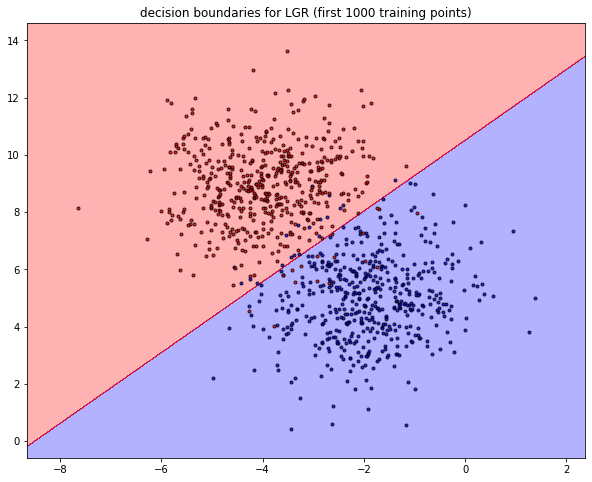

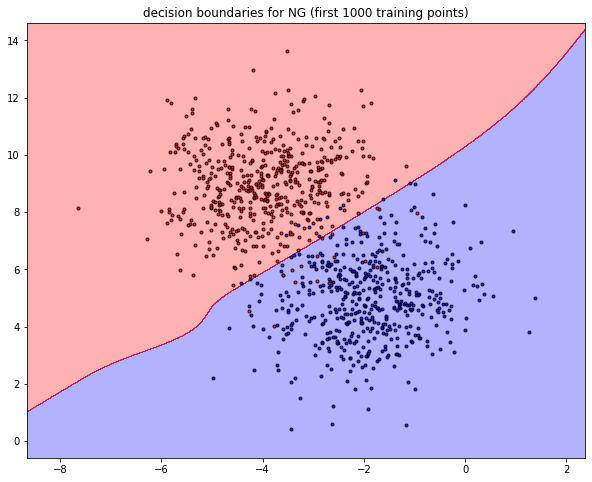

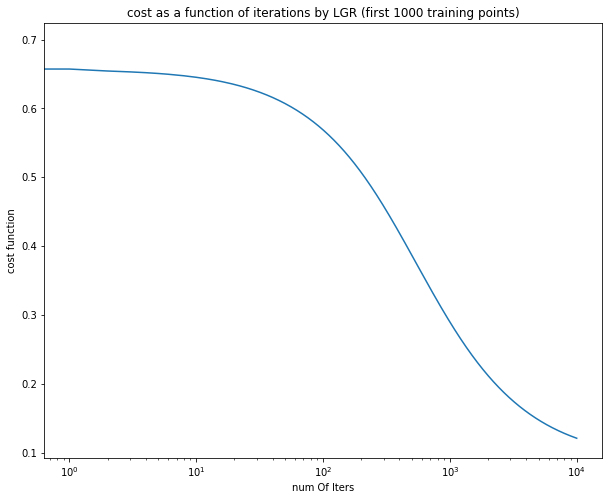

accuracy of LGR (all test points):  0.804
accuracy of NB (all test points): 0.873 



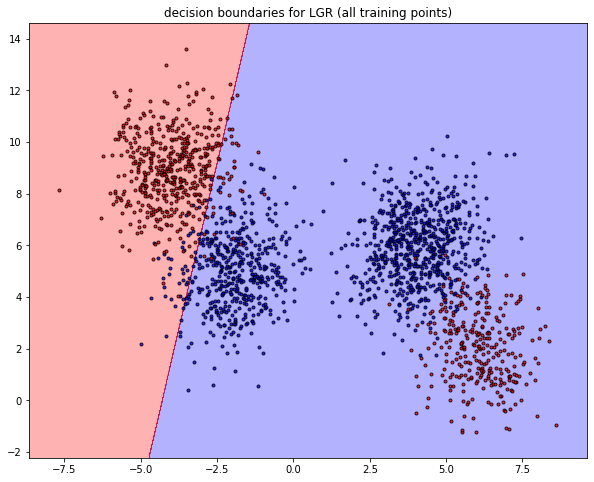

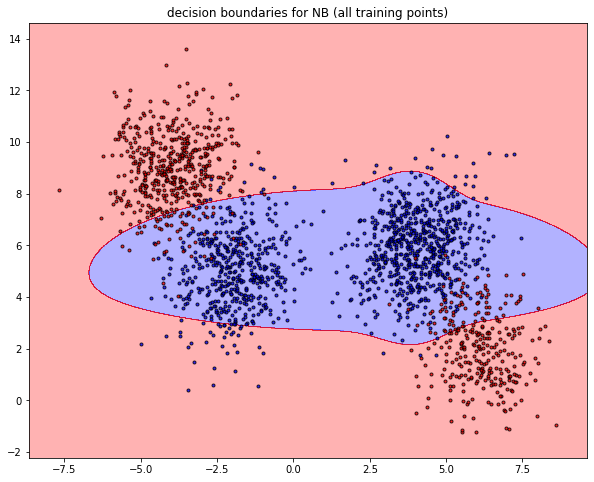

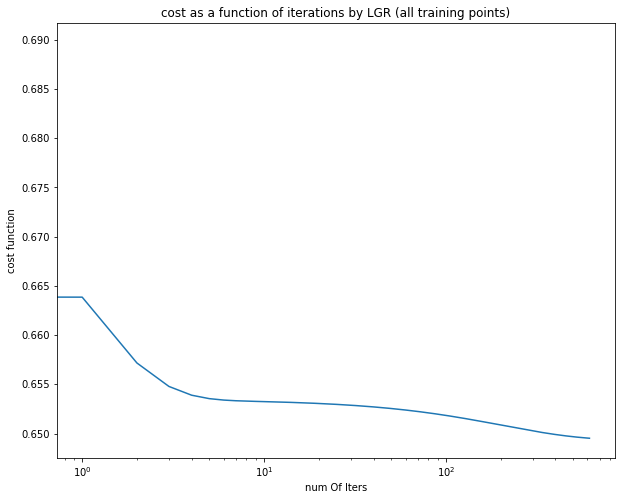

In [12]:
#### Your code here ####            
xtest500 = X_test[:500]
ytest500 = y_test[:500]

Xtrain1000 = X_training[:1000]
ytrain1000 = y_training[:1000]


LGR = LogisticRegressionGD(eta=bestEta, eps=bestEps)
LGR.fit(Xtrain1000,ytrain1000)
NB = NaiveBayesGaussian(2)
NB.fit(Xtrain1000,ytrain1000)

print("accuracy of first test point by LGR: ", LGR.accuracy(LGR.predict(xtest500), ytest500))
print("accuracy of first test points by NB: ", NB.accuracy(NB.predict(xtest500), ytest500), "\n")

plt.figure()
plt.title("decision boundaries for LGR (first 1000 training points)")
plot_decision_regions(Xtrain1000, ytrain1000, LGR, resolution=0.01)
plt.show()

plt.figure()
plt.title("decision boundaries for NG (first 1000 training points)")
plot_decision_regions(Xtrain1000, ytrain1000, NB, resolution=0.01)
plt.show()

plt.figure()
plt.title('cost as a function of iterations by LGR (first 1000 training points)')
plt.plot(np.arange(len(LGR.J_history)), LGR.J_history)
plt.xscale('log')
plt.xlabel('num Of Iters')
plt.ylabel('cost function')
plt.show()


LGR = LogisticRegressionGD(eta = bestEta, eps = bestEps)
LGR.fit(X_training,y_training)
NB = NaiveBayesGaussian(2)
NB.fit(X_training,y_training)

print("accuracy of LGR (all test points): ", LGR.accuracy(LGR.predict(X_test), y_test))
print("accuracy of NB (all test points):",  NB.accuracy(NB.predict(X_test), y_test), "\n")

plt.figure()
plt.title("decision boundaries for LGR (all training points)")
plot_decision_regions(X_training, y_training, LGR, resolution=0.01)
plt.show()

plt.figure()
plot_decision_regions(X_training, y_training, NB, resolution=0.01)
plt.title("decision boundaries for NB (all training points)")
plt.show()

plt.figure()
plt.title('cost as a function of iterations by LGR (all training points)')
plt.plot(np.arange(len(LGR.J_history)), LGR.J_history)
plt.xscale('log')
plt.xlabel('num Of Iters')
plt.ylabel('cost function')
plt.show()


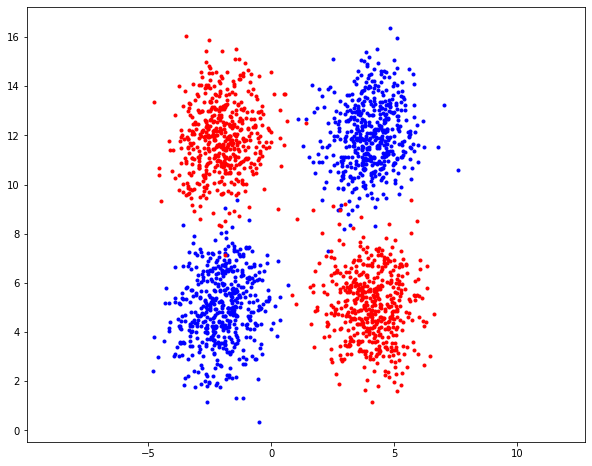

In [42]:
mean = [[-2,5], [-2, 12], [4, 12], [4, 5]]
cov = [[[1,0.2],[0.2,2]], [[1,0],[0,2]], [[1,0.2],[0.2,2]], [[1,-0.2],[-0.2,2]]]
x1 = []
x2 = []
y = []
size = [500, 500, 500, 500]
c = ['b', 'r']
for i in range(4):
    xx1,xx2 = np.random.multivariate_normal(mean[i],cov[i],size[i]).T
    x1.extend(xx1)
    x2.extend(xx2)
    y.extend([i%2] * size[i])
    plt.scatter(xx1,xx2, marker='.', c=c[i%2])
plt.axis('equal')
plt.show()

#### it is better to use full bayes on the above data rather than naive bayes.

As we examine this data we can conclude that the feature are dependent 
while naive bayes uses conditional independence assumption,
threrefore we would prefer to you full bayes to get better result.
while we know one of the features and the class we can know about the other feature, meaning dependet. 
